NOMS I COGNOMS: Zhipeng Lin, Zhihan Lin

GRUP: A

# Naive Bayes i Classificació


En aquest quart lliurament es programarà un classificador, que donat un tweet el categoritzarà en una de les possibles classes. En aquesta ocasió, implementareu un classificador amb tweets de cyber bullying.


**Què s’ha de fer?**

Volem classificar tweets segons a quin tipus de cyber bullying pertanyen. Així doncs, a partir de tots els tweets que tenim, crearem un vector de característiques que ens descrigui cadascun. Finalment desenvoluparem un classificador probabilístic del tipus Naive Bayes que ens permeti identificar a quina classe de cyber bullying pertany un tweet donat segons les característiques triades.


**Quina és la idea del sistema de classificació que s’ha de desenvolupar?**

El classificador és un concepte de l'aprenentatge automàtic supervisat. L'objectiu del classificador és donat un vector de característiques que descriuen els objectes que es volen classificar indicar a quina categoria o classe pertanyen d'entre un conjunt predeterminat. 

El procés de classificació consta de dues parts: 
(a) el procés d'aprenentatge i 
(b) el procés d'explotació o testeig. 
El procés d'aprenentatge rep exemples de parelles $(x,y)$ on $x$ són les característiques, usualment nombres reals, i $y$ és la categoria a la que pertanyen. 
Aquest conjunt se'l coneix com a conjunt d'entrenament i ens servirà per trobar una funció $\hat{y}=h(x)$ que donada una $x$ aconsegueixi que $\hat{y}=y$. Per altra banda el procés de testeig aplica la funció $h(x)$ apresa a l'entrenament a una nova descripció per veure quina categoria li correspon.


**Classificació i llenguatge natural**

La descripció dels exemples en característiques és el punt més crític de tot sistema d'aprenentatge automàtic. 
Una de les representacions més simples per tal de descriure un text és la representació *bag-of-words*.
Aquesta representació converteix un text en un vector de $N$ paraules. 
Consisteix en seleccionar un conjunt d'$N$ paraules i per cada paraula comptar quants cops apareix en el text. 
Una versió alternativa d'aquest procés pot ser simplement indicar si apareix o no en el text.

## Abans de començar


**\+ Durant la pràctica, solament es podran fer servir les següents llibreries**:

`Pandas, Numpy` i `NLTK`

*Nota: A més de les que ja es troben presents en la 1a cel·la i funcions natives de Python*

**\+ No es poden modificar les definicions de les funcions donades, ni canviar els noms de les variables i paràmetres ja donats**

Això no implica però que els hàgiu de fer servir. És a dir, que la funció tingui un paràmetre anomenat `df` no implica que l'hàgiu de fer servir, si no ho trobeu convenient.

**\+ En les funcions, s'especifica que serà i de quin tipus cada un dels paràmetres, cal respectar-ho**

Per exemple (ho posarà en el pydoc de la funció), `df` sempre serà indicatiu del `Pandas.DataFrame` de les dades. Durant els testos, els paràmetres (i específicament `df`) no contindran les mateixes dades que en aquest notebook, si bé si seran del mateix tipus! Per tant, no us refieu de què tinguin, per exemple, el mateix nombre de files.

## Més informació del dataset

El 15 d'Abril de 2020, UNICEF va llançar una alarma com a resposta de l'augment de risc de cyberbullying durant la pandèmia COVID-19. Les estadístiques són prou alarmants: un 36.5% dels estudiants de l'escola fins a l'institut s'han sentit víctimes del cyberbullying i un 87% l'han observat, amb efectes que van des d'una disminució de resultats acadèmics fins a pensaments suïcides.

Amb l'objectiu d'ajudar a l'analisis de la situació, s'ha construit un dataset que conté més de 47000 tweets etiquetats d'acord amb la classe de cyberbullying que s'està donant:

1. Age;
2. Ethnicity;
3. Gender;
4. Religion;
5. Other type of cyberbullying;
6. Not cyberbullying

Les dades han estat balancejades per tal de contenir aproximadament 8000 mostres de cada classe.

# Preparar les dades

## Llegim dades

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/cyberbullying_tweets.csv')
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [3]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

## Dividim dataset

Dividim els tweets en un conjunt d'entrenament, *train*, i en un conjunt de validació, *test*, per tal de poder entrenar i validar el nostre model de ML.

In [4]:
from sklearn.model_selection import train_test_split

df_tweets_train, df_tweets_test = train_test_split(df, test_size=0.2)

Com les dades estaven balancejades originalment, podem observar que la distribució de cadascuna de les classes es manté:

In [5]:
df_tweets_train['cyberbullying_type'].value_counts()

not_cyberbullying      6436
religion               6379
ethnicity              6377
age                    6371
gender                 6351
other_cyberbullying    6239
Name: cyberbullying_type, dtype: int64

In [6]:
df_tweets_test['cyberbullying_type'].value_counts()

gender                 1622
age                    1621
religion               1619
ethnicity              1584
other_cyberbullying    1584
not_cyberbullying      1509
Name: cyberbullying_type, dtype: int64

# Implementació

Dividirem el notebook en 3 seccions que es complementen una a l'altra:

1. Anàlisis de dades: Informació bàsica sobre els tweets
2. Processament de les dades: Creació d'un vector de característiques a partir dels tweets
3. Classificació amb Naive Bayes

### 1. Anàlisis de dades

El primer que haurem de fer és analitzar les dades per veure una mica com són. El que us proposem és fer una sèrie de plots per observar dades com ara:

* quants tweets s'estan dirigint a una persona en concret
* quants hastags hi ha a cada categoria de tweets
* quants tweets hi ha de cada categoria
* quants tweets de la categoria "not_cyberbullying" és dirigeixen a un usuari vs totes les altres categories
* altres coses que penseu que poden ser rellevants

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
df_tweets_train.head()

,tweet_text,cyberbullying_type
3505,RT @Spacekatgal: This is not just about servin...,not_cyberbullying
39112,Do you think Tall Girl is problematic consider...,age
24697,@katexweis @ashleylynch i'm more basic than ei...,other_cyberbullying
21483,@dankmtl @AAlwuhaib1977 @PeaceNotHate_ Your fr...,religion
1428,Photo: › Bullying: Ato idiota de estragar a vi...,not_cyberbullying


#### **EXERCICI 1:** FEU EL VOSTRE ANALISIS DE DADES AQUÍ

> your code here

In [9]:
def plot_tweets_to_person(data_frame):
    """
    Plot the numbers of tweets directed to a concrete person,
    and numbers of tweets not directed to a concrete person
    :param data_frame: DataFrame
    """
    tweet_texts_list = data_frame['tweet_text']
    # a string contain a character @ of size 1, means it's directed to a concrete person
    counts = tweet_texts_list.str.count('@')
    counts = counts == 1

    # Number of Ture, directed to a person, and number of False
    len_counts = len(counts)
    num_true = sum(counts)
    num_false = len_counts - num_true

    name = ["Directed to a concrete person", "Not directed to one concrete person"]
    values = [num_true, num_false]

    plt.title("Tweets directed to a person")
    plt.bar(name, values, width=0.3)
    plt.show()
def total_hastags_in_tweet(data_frame):
    # Different type of cyberbullying
    types = data_frame["cyberbullying_type"].unique()
    values = []

    # Count number of # in each category
    for type in types:
        # get the interested data
        mask = data_frame["cyberbullying_type"] == type
        interested_data = data_frame[mask]
        total_count = sum(interested_data['tweet_text'].str.count('#'))
        values.append(total_count)

    plt.title("Number of #")
    plt.bar(types, values, width=0.3)
    plt.show()
def total_num_of_tweet_by_category(data_frame):
    data = data_frame.groupby("cyberbullying_type").count()
    data.plot.bar()
    plt.show()
def tweet_no_cyberbullying_to_user(data_frame):
    mask = data_frame["cyberbullying_type"] == "not_cyberbullying"

    not_cyberbullying = data_frame[mask]
    cyberbullying = data_frame[~mask]

    counts_not_cyberbullying = not_cyberbullying['tweet_text'].str.count('@')
    counts_not_cyberbullying = counts_not_cyberbullying == 1
    counts_not_cyberbullying = sum(counts_not_cyberbullying)

    counts_cyberbullying = cyberbullying['tweet_text'].str.count('@')
    counts_cyberbullying = counts_cyberbullying == 1
    counts_cyberbullying = sum(counts_cyberbullying)

    types = ["Not Cyberbullying", "Other"]
    values = [counts_not_cyberbullying, counts_cyberbullying]

    plt.title("Directed to one user")
    plt.bar(types, values, width=0.3)
    plt.show()



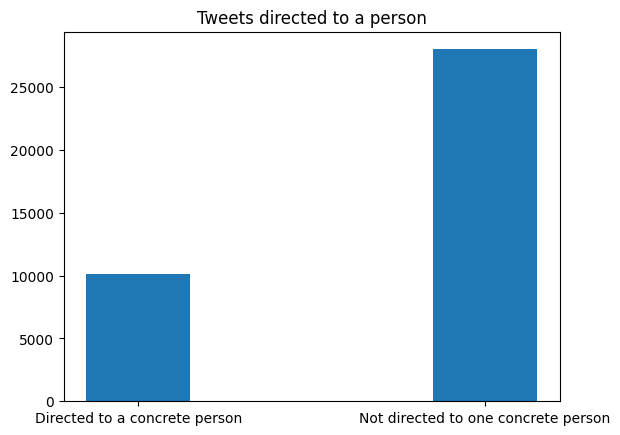

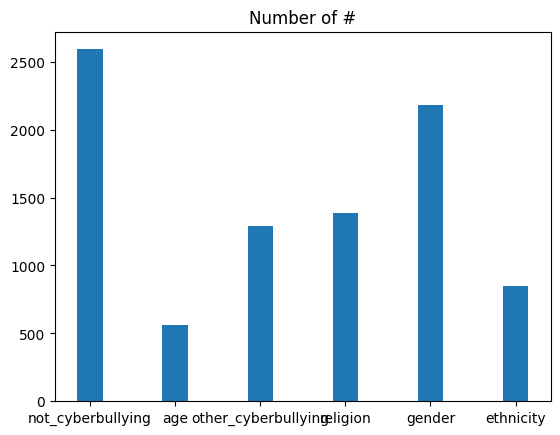

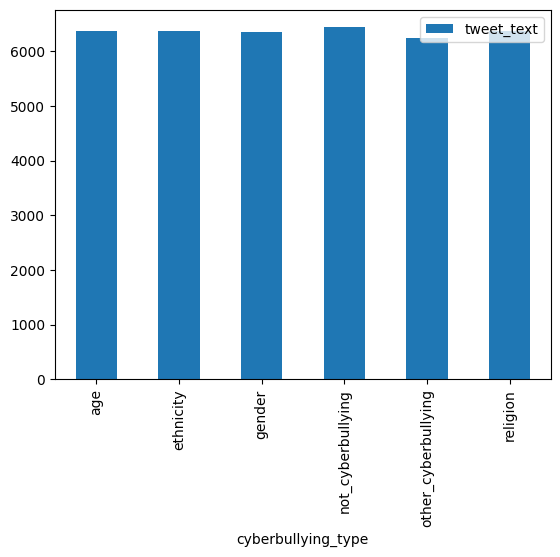

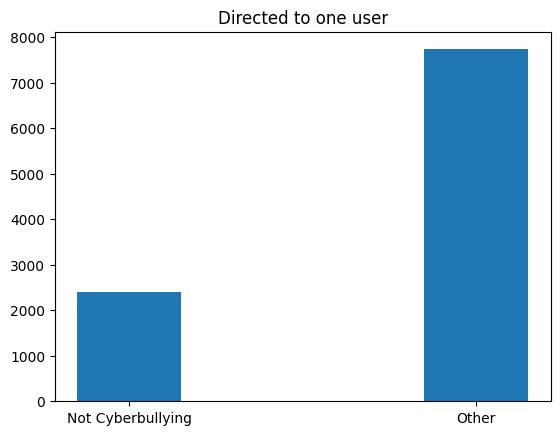

In [10]:
functions = [plot_tweets_to_person, total_hastags_in_tweet, total_num_of_tweet_by_category, tweet_no_cyberbullying_to_user]

for fn in functions:
    fn(df_tweets_train)

### Comptar paraules

El primer que haurem d'implementar és la funció *normalize* que normalitzarà les paraules.


No modificar la següent cel·la, s'encarrega de fer el proce

In [11]:
def memo(f):
    class memodict(dict):
        def __init__(self, f):
            self.f = f
        def __call__(self, *args):
            return self[args]
        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret
    return memodict(f)

#### **EXERCICI 2:** 

Empleneu la funció següent que, donada una paraula, la normalitzi passant tots els digits a minúscules.

In [12]:
@memo    
def normalize(word):
    """
    Funció que donada una paraula la normalitzi
    Exemple: Taller DELS noUS USOS ---> tallers dels nous usos
    
    :param word: paraula a normalitzar
    :return : paraula normalitzada
    """
    
    # YOUR CODE HERE

    return word.lower()

#### **EXERCICI 3:** 

Feu una funció que construeixi un diccionari que contingui totes les paraules que s'han trobat tot indicant el total de cops que ha aparegut cadascuna i el nombre de tweets on apareix. Més a baix teniu un exemple de l'estructura que ha de tenir el output de la funció.

In [13]:
def count_words(df):
    """
    Funció que ha de construir un diccionari que contingui totes les paraules que s'han trobat indicant
    el total de cops que ha aparegut i el nombre de tweets on apareix
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : Diccionari amb el format {word : {n_ocur: valor, n_tweets: valor}, ...}
    """

    # YOUR CODE HERE

    word_dicc = {}
    tweet_set = set()
    list_tweet_text = df['tweet_text'].str.replace(r'[^\w\s\']+', '').str.split(pat=" ")

    for tweet in list_tweet_text:
        for word in tweet:
            word = normalize(word)
            if word not in word_dicc.keys():
                word_dicc[word] = {'n_ocur': 1, 'n_tweets': 0}
            else:
                word_dicc[word]['n_ocur'] += 1

            if(word not in tweet_set):
                word_dicc[word]['n_tweets'] += 1
                tweet_set.add(word)
        tweet_set.clear()

    return word_dicc

In [14]:
dicc_text = count_words(df_tweets_train)
print (len(dicc_text))

C:\Users\zhipe\AppData\Local\Temp\ipykernel_32112\3924668493.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  list_tweet_text = df['tweet_text'].str.replace(r'[^\w\s\']+', '').str.split(pat=" ")


58498


El resultat serà un diccionari tipus (no necessàriament amb aquest valors):

```python
{
    'memory' : {'n_ocur': 88, 'n_tweets': 76},
    'best': {'n_ocur': 123, 'n_tweets': 65},
    ...
}
```

### Contar paraules per cada categoria de tweet

In [15]:
df_tweets_train.head()

,tweet_text,cyberbullying_type
3505,RT @Spacekatgal: This is not just about servin...,not_cyberbullying
39112,Do you think Tall Girl is problematic consider...,age
24697,@katexweis @ashleylynch i'm more basic than ei...,other_cyberbullying
21483,@dankmtl @AAlwuhaib1977 @PeaceNotHate_ Your fr...,religion
1428,Photo: › Bullying: Ato idiota de estragar a vi...,not_cyberbullying


#### **EXERCICI 4:** 

Fent servir la funció que se us dona a continuació (eachTopic), apliqueu-la per tal de comptar les paraules que s'han trobat i la seva ocurrència segregant ara per categoria.

In [16]:
def count_words_categories(df):
    """
    Funció que ha de constuir un diccionari que conté la freqüència de les 
    paraules i el número de tweets on ha aparegut. 
    Aquesta informació ha de ser dividida per diferents categories de cyberbullying.
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : Diccionari amb el format {label : {word : {n_ocur: valor, n_news: valor} } }
    """
    words_topic = {}
    
    def eachTopic(group):
        # Count words on this topic and save to dictionary
        words_topic[group['cyberbullying_type'].iloc[0]] = count_words(group)

    # Group by topics and apply function to each topic
    
    allTopics = df.groupby('cyberbullying_type')

    for label,topic in allTopics:
        eachTopic(topic)

    return words_topic

In [17]:
words_categories = count_words_categories(df_tweets_train)
print (len(words_categories))

C:\Users\zhipe\AppData\Local\Temp\ipykernel_32112\3924668493.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  list_tweet_text = df['tweet_text'].str.replace(r'[^\w\s\']+', '').str.split(pat=" ")


6


El resultat serà un diccionari tipus (no necessàriament amb aquest valors):

```python
{
    'ethnicity': {
        'race' : {'n_ocur': 88, 'n_tweets': 76},
        'what': {'n_ocur': 123, 'n_tweets': 65}
        ...
    },
    ...
    'gender': {
        'jokes' : {'n_ocur': 18, 'n_tweets': 17},
        'you': {'n_ocur': 154, 'n_tweets': 66}
    }
    ...
}
```

### Paraules més freqüents als tweets


**El problema de com escollir el vector de carecterístiques**

L'elecció de les paraules que formen el vector de característiques és un pas crític. En funció de com de bona sigui aquesta descripció, millor funcionarà el sistema. Tot i que us deixem a vosaltres la política de creació del vector de característiques us donem una pista: per saber quines paraules fer servir una possible estratègia és agafar aquelles paraules que apareixen entre en un 10 i un 50 percent del total (sense tenir en compte la categoria). 

Podeu experimentar variant aquests valors.

#### **EXERCICI 5:** 

Experimenteu omplint la llista *skip_top* amb aquelles paraules que penseu no tenen significat o relevancia per definir cada categoria. Podeu buscar informació sobre **stop words** a internet i definir varies llistes fins que penseu que obteniu una bona representació de paraules per categoria de cyberbullying.

In [18]:
import  nltk
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhipe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [24]:
skip_word = nltk.corpus.stopwords.words("english")
manual_skip_word = ["","u","","like","one","im","people","got","middle","get","would","dont","amp","know","back","didnt","mean","really","time","still","think","go","never","even","always","also","see", "used","every","said","way","went","day","look","say","everyone","good","want","getting","youre","someone","friends","much", "ur","rt","called","tayyoung","first","anything","yall", "call","funny","mkr","make","making","cant","made", 'ive', 'shit', 'e', 'need', 'thats', 'well', 'que', 'oh', 'going', 'é', 'de','lol','mkr2015', 'right', 'radical','us','r']

skip_word = np.concatenate((skip_word, manual_skip_word))


In [25]:
skip_top = ['', 'a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 'approximately', 'are', 'aren', 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'between', 'beyond', 'biol', 'both', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'came', 'can', 'cannot', "can't", 'cause', 'causes', 'certain', 'certainly', 'co', 'com', 'come', 'comes', 'contain', 'containing', 'contains', 'could', 'couldnt', 'd', 'date', 'did', "didn't", 'different', 'do', 'does', "doesn't", 'doing', 'done', "don't", 'down', 'downwards', 'due', 'during', 'e', 'each', 'ed', 'edu', 'effect', 'eg', 'eight', 'eighty', 'either', 'else', 'elsewhere', 'end', 'ending', 'enough', 'especially', 'et', 'et-al', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'except', 'f', 'far', 'few', 'ff', 'fifth', 'first', 'five', 'fix', 'followed', 'following', 'follows', 'for', 'former', 'formerly', 'forth', 'found', 'four', 'from', 'further', 'furthermore', 'g', 'gave', 'get', 'gets', 'getting', 'give', 'given', 'gives', 'giving', 'go', 'goes', 'gone', 'got', 'gotten', 'h', 'had', 'happens', 'hardly', 'has', "hasn't", 'have', "haven't", 'having', 'he', 'hed', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'heres', 'hereupon', 'hers', 'herself', 'hes', 'hi', 'hid', 'him', 'himself', 'his', 'hither', 'home', 'how', 'howbeit', 'however', 'hundred', 'i', 'id', 'ie', 'if', "i'll", 'im', 'immediate', 'immediately', 'importance', 'important', 'in', 'inc', 'indeed', 'index', 'information', 'instead', 'into', 'invention', 'inward', 'is', "isn't", 'it', 'itd', "it'll", 'its', 'itself', "i've", 'j', 'just', 'k', 'keep\tkeeps', 'kept', 'kg', 'km', 'know', 'known', 'knows', 'l', 'largely', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let', 'lets', 'like', 'liked', 'likely', 'line', 'little', "'ll", 'look', 'looking', 'looks', 'ltd', 'm', 'made', 'mainly', 'make', 'makes', 'many', 'may', 'maybe', 'me', 'mean', 'means', 'meantime', 'meanwhile', 'merely', 'mg', 'might', 'million', 'miss', 'ml', 'more', 'moreover', 'most', 'mostly', 'mr', 'mrs', 'much', 'mug', 'must', 'my', 'myself', 'n', 'na', 'name', 'namely', 'nay', 'nd', 'near', 'nearly', 'necessarily', 'necessary', 'need', 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nine', 'ninety', 'no', 'nobody', 'non', 'none', 'nonetheless', 'noone', 'nor', 'normally', 'nos', 'not', 'noted', 'nothing', 'now', 'nowhere', 'o', 'obtain', 'obtained', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'omitted', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'ord', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'owing', 'own', 'p', 'page', 'pages', 'part', 'particular', 'particularly', 'past', 'per', 'perhaps', 'placed', 'please', 'plus', 'poorly', 'possible', 'possibly', 'potentially', 'pp', 'predominantly', 'present', 'previously', 'primarily', 'probably', 'promptly', 'proud', 'provides', 'put', 'q', 'que', 'quickly', 'quite', 'qv', 'r', 'ran', 'rather', 'rd', 're', 'readily', 'really', 'recent', 'recently', 'ref', 'refs', 'regarding', 'regardless', 'regards', 'related', 'relatively', 'research', 'respectively', 'resulted', 'resulting', 'results', 'right', 'run', 's', 'said', 'same', 'saw', 'say', 'saying', 'says', 'sec', 'section', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sent', 'seven', 'several', 'shall', 'she', 'shed', "she'll", 'shes', 'should', "shouldn't", 'show', 'showed', 'shown', 'showns', 'shows', 'significant', 'significantly', 'similar', 'similarly', 'since', 'six', 'slightly', 'so', 'some', 'somebody', 'somehow', 'someone', 'somethan', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'sorry', 'specifically', 'specified', 'specify', 'specifying', 'still', 'stop', 'strongly', 'sub', 'substantially', 'successfully', 'such', 'sufficiently', 'suggest', 'sup', 'sure\tt', 'take', 'taken', 'taking', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that've", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'thered', 'therefore', 'therein', "there'll", 'thereof', 'therere', 'theres', 'thereto', 'thereupon', "there've", 'these', 'they', 'theyd', "they'll", 'theyre', "they've", 'think', 'this', 'those', 'thou', 'though', 'thoughh', 'thousand', 'throug', 'through', 'throughout', 'thru', 'thus', 'til', 'tip', 'to', 'together', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'ts', 'twice', 'two', 'u', 'un', 'under', 'unfortunately', 'unless', 'unlike', 'unlikely', 'until', 'unto', 'up', 'upon', 'ups', 'us', 'use', 'used', 'useful', 'usefully', 'usefulness', 'uses', 'using', 'usually', 'v', 'value', 'various', "'ve", 'very', 'via', 'viz', 'vol', 'vols', 'vs', 'w', 'want', 'wants', 'was', 'wasnt', 'way', 'we', 'wed', 'welcome', "we'll", 'went', 'were', 'werent', "we've", 'what', 'whatever', "what'll", 'whats', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whim', 'whither', 'who', 'whod', 'whoever', 'whole', "who'll", 'whom', 'whomever', 'whos', 'whose', 'why', 'widely', 'willing', 'wish', 'with', 'within', 'without', 'wont', 'words', 'world', 'would', 'wouldnt', 'www', 'x', 'y', 'yes', 'yet', 'you', 'youd', "you'll", 'your', 'youre', 'yours', 'yourself', 'yourselves', "you've", 'z', 'zer', 'i\'m', 'é', 'lol', 'going']

skip_top = np.concatenate((skip_top, skip_word))

def topNwords(df, words, N, skip=[]):
    """
    Funció que crea un diccionari amb les N paraules més representatives 
    (les que apareixen amb més freqüència) de cadascuna de les categories de cyberbullying.
    
    Tingueu en compte que també haureu de filtrar aquelles paraules que apareixen en la majoria 
    de tweets, així com també, les que únicament apareixen en un conjunt molt petit de tweets
    
    :param df: DataFrame amb els tweets i la informació associada
    :param words: diccionari amb les paraules i la seva frequencia
    :param N: número de paraules més representatives que volem considerar
    :return : Diccionari amb el format {categoria1: llista_top_words_cat_1,  
                                        categoria2: llista_top_words_cat_2, ...} 
    """
    top_words=dict()
    
    def each_word(topic, word):
        if word not in skip:
            return words[topic][word]['n_ocur']
        return 0
    
    for topic in words:
        top_words[topic] = sorted(words[topic], key=lambda x: each_word(topic, x))[-N:][::-1]
    
    return top_words

In [26]:
top_words = topNwords(df_tweets_train, words_categories, 20, skip_top)

In [27]:
top_words

{'age': ['school',
  'high',
  'bullied',
  'bully',
  'girls',
  'girl',
  'bullies',
  'kids',
  'schools',
  'life',
  'bullying',
  'years',
  'kid',
  'grade',
  'year',
  'friend',
  'black',
  'bad',
  'love',
  'feel'],
 'ethnicity': ['fuck',
  'dumb',
  'nigger',
  'ass',
  'black',
  'white',
  'niggers',
  'obama',
  'tayyoung_',
  'bitch',
  'racism',
  'fucking',
  'negro',
  'racist',
  'disgusting',
  'colored',
  'mad',
  'man',
  'nigga',
  'stupid'],
 'gender': ['rape',
  'gay',
  'jokes',
  'joke',
  'sexist',
  'bitch',
  'female',
  'women',
  'men',
  'man',
  'fucking',
  'gays',
  'bitches',
  'females',
  'woman',
  'girls',
  'feminazi',
  'prison',
  'hate',
  'kat'],
 'not_cyberbullying': ['bullying',
  'bully',
  'school',
  'kat',
  'love',
  'andre',
  'women',
  'class',
  'twitter',
  'isis',
  "that's",
  'fuck',
  'today',
  'se',
  'bad',
  'hate',
  'sure',
  'eu',
  'fucking',
  'thing'],
 'other_cyberbullying': ['bully',
  'fucking',
  'bullying',

El resultat serà un diccionari tipus (no necessàriament amb aquest valors):

```python
{
    'age': ['school', 'high', ...],
    ...
    'religion': ['muslims', 'christian',...]
    ...
}
```

> Una pista de que aneu ben encaminats es que per cadascuna de les categories de cyberbullying obtingueu paraules rellevants per aquesta. Si no es així, vol dir que heu d'incrementar el nombre de paraules a saltar (*skip_top*).

> EXPERIMENTEU AQUÍ QUÈ PASSA SEGONS LES "STOP WORDS" QUE USEU.

### Vector de Característiques

#### **EXERCICI 6:** 

Creeu el vector de característiques necessari per a fer l’entrenament del Naïve Bayes.

In [81]:
def create_features(df, top_words): 
    """
    Funció que crea un vector de característiques necessari per a l'entrenament del classificador Naive Bayes
    
    :params df: DataFrame amb els tweets i la informació associada
    :params top_words: ha de ser el diccionari que retorna topNWords
    :return : diccionari o pd.Series que conté un np.array per a 
        cadascuna dels tweets amb el vector de característiques corresponent.
    """
    
    # YOUR CODE HERE
    mask_word = np.asarray([])
    for word in top_words.values():
        mask_word = np.concatenate((mask_word, word))

    matrix = np.asarray([])
    for word in mask_word:
        word_mask = df['tweet_text'].str.contains(word)
        array = word_mask.to_numpy().astype(int)
        if matrix.size == 0 :
            matrix = np.asarray([array])
        else:
            matrix = np.concatenate((matrix, [array]), axis=0)
    matrix = matrix.T

    result = {}
    for idx, array in enumerate(matrix):
        result[idx] = array
    return  result

In [82]:
N = 20 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor.
words_categories = count_words_categories(df_tweets_train)
top_words = topNwords(df_tweets_train, words_categories, N, skip_top)
dict_feat_vector = create_features(df_tweets_train, top_words)

C:\Users\zhipe\AppData\Local\Temp\ipykernel_32112\3924668493.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  list_tweet_text = df['tweet_text'].str.replace(r'[^\w\s\']+', '').str.split(pat=" ")


In [87]:
len(dict_feat_vector)

38153

El resultat serà un diccionari tipus (no necessàriament amb aquest valors):

```python
{
    0: np.array([0, 1, 1, 0, ...]),
    1: np.array([0, 1, 1, 1, ...]),
    ...
}
```

Com podem observar, hi ha un vector de característiques per cadascun dels tweets en entrenament. El que esperem és que aquest vector ens estigui donant informació del que posa a cada tweet.

In [88]:
df_tweets_train.shape

(38153, 2)

### El classificador Naïve Bayes

Un cop tenim una representació necessitem un procés d'aprenentatge que ens permeti passar de la descripció a una categoria. 
En aquest lliurament farem servir el classificador Naïve Bayes. 
Aquest classificador forma part de la família de classificadors probabilístics. 
La sortida d'un classificador probabilístic és un valor de probabilitat donat un exemple per cadascuna de les categories. 
La decisió final correspon a la categoria amb més probabilitat. 


Els classificadors probabilistics Bayesians es basen en el teorema de Bayes per realitzar els càlculs per trobar la probabilitat condicionada: 
$$ p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$
d'on podem extreure que: 
$$ p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$


En molts casos $p(y)$ i $p(x)$ són desconeguts i es consideren equiprobables. 
Per tant, la decisió es simplifica a:
$$ p(y|x) = p(y) · p(x|y)$$


Les deduccions fins a aquest punt són vàlides per la majoria de classificadors Bayesians. 
Naïve Bayes es distingeix de la resta perquè imposa una condició encara més restrictiva. 
Considerem $x=(x_1, \cdots, x_n)$ un conjunt d'$N$ variables aleatòries. 
Naïve Bayes assumeix que totes elles són independents entre elles i per tant podem escriure:
$$p(x_1,x_2,...,x_N | y) = p(x_1|y)p(x_2|y)...p(x_N|y)$$


Podem interpretar l'anterior equació de la següent forma: La probabilitat de que el tweet descrit pel vector de característiques (0,1,0,1,1,1) sigui de la classe "gender" és proporcional al producte de la probabilitat que la primera paraula del vector no aparegui en els tweets sobre "gender" per la probabilitat que la segona paraula sí que hi aparegui, etc.


**Estimant les probabilitats marginals condicionades**

L'últim pas que ens queda és trobar el valor de les probabilitats condicionades. 
Farem servir la representació de $0$'s i $1$'s indicant que la paraula no apareix (0) o sí apareix (1) a al tweet. 
Per trobar el valor de la probabilitat condicionada farem servir una aproximació freqüentista a la probabilitat. 
Això vol dir que calcularem la freqüència d'aparició de cada paraula per a cada categoria. 
Aquest càlcul es fa dividint el nombre de tweets de la categoria en que apareix la paraula pel nombre total de tweets d'aquella categoria. 

En gneral:
$$p(x = \text{"school"} | y = C)= \frac{A}{B} $$
on A és el número de tweets de la categoria C on hi apareix la paraula 'school' i B és el número total de tweets de la categoria C.


### Punts dèbils:

**El problema de la probabilitat 0**

Si us hi fixeu bé, la probabilitatpot ser 0 !!  Això vol dir, que si en el tweet no hi apareix una paraula no pot ser classificada com cap tipus de cyber bullying.

No sembla raonable que s'assigni o no en aquesta categoria segons si en el tweet hi apareix o no una única paraula. 
Per tant, el que s'acostuma a fer és donar una baixa probabilitat en comptes de zero. 
Una de les possibles solucions es fer servir la correcció de Laplace. 
Seguint l'exemple anterior la correcció de Laplace és
$$p(x= \text{"school"} | y = 'C' ) = \frac{A+1}{B+M}$$ 
on M és el nombre de categories

**El problema del "underflow"**

La funció que hem de calcular en el Naive Bayes és un producte. 
El nombre de caractéristiques del vector és el nombre de termes del producte. 
Aquests nombres són iguals o menors a 1, si els multipliquem tots entre ells el resultat serà massa petit per a representar-lo en un nombre de punt flotant i el càlcul acabarà sent reduït a zero. 
Per solucionar aquest problema en comptes d'operar fent multiplicacions, se sol passar a l'escala logarítmica i allà operar fent servir sumes en comptes de multiplicacions.

#### **EXERCICI 7:** 

Implementeu la funció d'aprenentatge del classificador Naïve Bayes (funció **naive_bayes_learn()**). La funció ha de mostrar per pantalla el resultat obtingut 
L'**error d'entrenament** es troba calculant el percentatge d'errors que s'obtenen quan es fa el testeig amb les mateixes dades utilizades per fer entrenament (aprenentatge). Aquest error es un valor molt optimista de com funcionarà el clasificador i mai s'ha de prendre com a mesura per comparar clasificadors. 

1) Programeu la funció **naive_bayes_learn** per a que estimi les probabilitats marginals condicionades.
2) Programeu la funció **naive_bayes** que implementa el classificador. Noteu que aquesta funció está guiada i només haureu d'emplenar els espais on hem posat tres punts suspensius "#···".

In [135]:
def dict_to_matrix(dict):
    result = np.asarray([])
    for value in dict.values():
        if len(result) == 0:
            result = [value]
        else:
            result = np.concatenate((result, [value]),axis=0)
    return result

[[1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]


In [120]:
def naive_bayes_learn(df, feats):
    """
    Funció que estima les probabilitats marginals condicionades.
    
    :params df: DataFrame amb els tweets i la informació associada
    :params feats: vector de característiques de cada tweet
    :return : probabilitats marginals condicionades
    """
    
    # YOUR CODE HERE
    len_of_feature = len(feats[0])
    matrix = dict_to_matrix(feats) # tweet -> words

    result = {}
    category = df['cyberbullying_type'].unique()
    for cate in category:
        new_df = df[df['cyberbullying_type'] == cate]
        total_num_of_tweet_of_cate = len(new_df) # B



    #return probs
naive_bayes_learn(df_tweets_train, dict_feat_vector)

TypeError: 'builtin_function_or_method' object is not iterable

In [113]:
import sys
from IPython import embed
def naive_bayes(df_train, feat_train, feat_test=None, df_test=None):
    """
    Funció que implementa el clasificador Naive_Bayes.
    
    Si df_test no és None, ha de calcular l'encert sobre les dades de test. És a dir,
    després de classificar feat_test ha de comparar la classificació amb la classe
    real i dir (print) quin percentatge d'encert ha obtingut.
    
    :param df_train: DataFrame amb els tweets que s'utilitzaran per l'entrenament
    :param feat_train: Diccionari amb els vectors de caracteristiques de cada tweet de l'entrenament
    :param feat_test: Diccionari amb els vectors de caracteristiques de cada tweet de test
    :param df_test: DataFrame amb els tweets que s'utilitzaran pel test
    
    :return : Una serie on l'index correspon amb els indexos de df_test i els valors són la
        classificació retornada per Naive Bayes
    """
    probs = naive_bayes_learn(df_train, feat_train)
    p_of_cat = count_words_categories(df_train)
    p_total = len(p_of_cat.keys())
    
    def eachFeats(row):
        id, feat = row
        p_max = float('-inf')
        p_cat = 0

        for category in probs:
            # Speed up by using numpy
            # inv is the inverse of features, 0 where 1 and 1 where 0
            # ...
            
            # Probs * feats is the probability of being there, while
            # inv - inv * feat = 1 - (0, 1, 0... inverses) * probs, probability of not being there
            # ...
            
            # Sum of logs [vs] underflow caused by mul of probs
            # ...

            # Take the max, do it now to avoid extra-loops
            # ...
                
        return id, p_cat
    
    data = map(eachFeats, feat_test.items())
    data = pd.Series(dict(data))
    correct = data == df_test['cyberbullying_type']
    print("Accuracy: {}".format(correct.sum() / correct.size))
    
    return correct.sum() / correct.size

IndentationError: expected an indented block after 'for' statement on line 28 (3858535097.py, line 43)

In [92]:
N = 20 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor.
words_topics = count_words_categories(df_tweets_train)
top_words = topNwords(df_tweets_train, words_topics, N, skip_top)

feat_train = create_features(df_tweets_train, top_words)
feat_test = create_features(df_tweets_test, top_words)

C:\Users\zhipe\AppData\Local\Temp\ipykernel_32112\3924668493.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  list_tweet_text = df['tweet_text'].str.replace(r'[^\w\s\']+', '').str.split(pat=" ")


In [93]:
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

NameError: name 'naive_bayes' is not defined

Haurieu d'obtenir una accuracy del 69-70%. Si heu arribat a això ja està bé! 

En canvi, per aquells que vulguin tenir alguns **PUNTS EXTRA**, us retem a aconseguir una accuracy més alta. A veure què podeu fer!!!



**IMPLEMENTACIÓ DE MILLORA**: